In [1]:
from keras.datasets import boston_housing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.regularizers import l2, l1
from sklearn.model_selection import KFold
import random
random.seed(1234)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# I run this console in kaggle, therefore we could see this IO rather than directly load_data()
train_data= pd.read_csv('../input/train_data.csv', usecols=range(1,14))
train_targets = pd.read_csv('../input/train_targets.csv', usecols=range(1,2))
test_data = pd.read_csv('../input/test_data.csv', usecols=range(1,14))
test_targets = pd.read_csv('../input/test_targets.csv', usecols=range(1,2))
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std

In [3]:
def k_fold_eval(train_data, train_targets, network, num_epoch, num_batch):
    k = 10
    num_val_samples = len(train_data) // k
    all_scores = []
    histories = []
    for i in range(k):
        print('processing fold #', i)
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],
                                               axis=0)
        history = network.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=num_batch, verbose=0)
        histories.append(history)
        val_mse = history.history['mean_squared_error']
        all_scores.append(val_mse)
    return all_scores, histories

In [4]:
class Network():
    def __init__(self, epcohs):
        self._model = models.Sequential()
    def compile(self):
        self._model.add(layers.Dense(1))
        self._model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])   
    def baseline(self):
        self._model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
        self._model.add(layers.Dense(64, activation='relu'))
        self.compile()
    def dropout(self):
        self._model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
        self._model.add(layers.Dropout(0.5))
        self._model.add(layers.Dense(64, activation='relu'))
        self._model.add(layers.Dropout(0.5))
        self.compile()
    def l1(self):
        self._model.add(layers.Dense(64, kernel_regularizer=l1(0.001), activation='relu', input_shape=(train_data.shape[1],)))
        self._model.add(layers.Dense(64, kernel_regularizer=l1(0.001), activation='relu'))
        self.compile()
    def l2(self):
        self._model.add(layers.Dense(64, kernel_regularizer=l2(0.001), activation='relu', input_shape=(train_data.shape[1],)))
        self._model.add(layers.Dense(64, kernel_regularizer=l2(0.001), activation='relu'))
        self.compile()
    def get_network(self):
        return self._model

In [5]:
num_epochs = 200
num_batches = 20
network = Network(num_epochs)
network.baseline()
network1 = network.get_network()
network = Network(num_epochs)
network.dropout()
network2 = network.get_network()
network = Network(num_epochs)
network.l1()
network3 = network.get_network()
network = Network(num_epochs)
network.l2()
network4 = network.get_network()
scores1, histroies1 = k_fold_eval(train_data, train_targets, network1, num_epochs, num_batches)
scores2, histroies2 = k_fold_eval(train_data, train_targets, network1, num_epochs, num_batches)
scores3, histroies3 = k_fold_eval(train_data, train_targets, network1, num_epochs, num_batches)
scores4, histroies4 = k_fold_eval(train_data, train_targets, network1, num_epochs, num_batches)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


In [14]:
mse1 = [np.mean([x[i] for x in scores1]) for i in range(num_epochs)]
mse2 = [np.mean([x[i] for x in scores2]) for i in range(num_epochs)]
mse3 = [np.mean([x[i] for x in scores3]) for i in range(num_epochs)]
mse4 = [np.mean([x[i] for x in scores4]) for i in range(num_epochs)]

Text(0.5,1,'Validation MSE by Comparison')

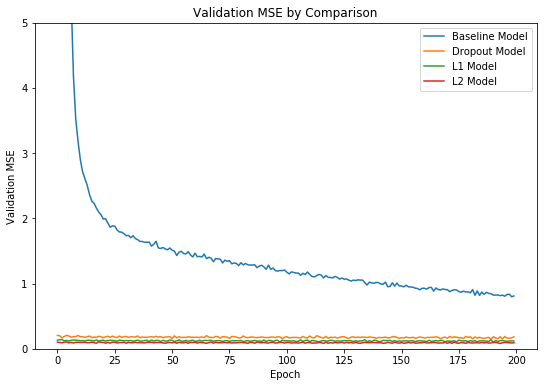

In [15]:
plt.figure(figsize=(9,6))
nxvals = np.arange(0,200)
plt.plot(nxvals, mse1, label='Baseline Model')
plt.plot(nxvals, mse2, label='Dropout Model')
plt.plot(nxvals, mse3, label='L1 Model')
plt.plot(nxvals, mse4, label='L2 Model')
plt.xlabel("Epoch")
plt.ylabel("Validation MSE")
plt.ylim(0,5)
plt.legend(loc='best')
plt.title("Validation MSE by Comparison")

In [16]:
final = Network(500)
final.l2()
network_final = final.get_network()
network_final.fit(train_data, train_targets, epochs=500, batch_size=12)

Epoch 1/500
404/404 [==============================] - 0s 847us/step - loss: 469.3351 - mean_squared_error: 469.2488
Epoch 2/500
404/404 [==============================] - 0s 275us/step - loss: 236.4378 - mean_squared_error: 236.3433
Epoch 3/500
404/404 [==============================] - 0s 272us/step - loss: 74.1791 - mean_squared_error: 74.0752
Epoch 4/500
404/404 [==============================] - 0s 272us/step - loss: 38.1070 - mean_squared_error: 38.0000
Epoch 5/500
404/404 [==============================] - 0s 280us/step - loss: 28.3246 - mean_squared_error: 28.2188
Epoch 6/500
404/404 [==============================] - 0s 258us/step - loss: 23.3446 - mean_squared_error: 23.2406
Epoch 7/500
404/404 [==============================] - 0s 277us/step - loss: 20.9131 - mean_squared_error: 20.8112
Epoch 8/500
404/404 [==============================] - 0s 280us/step - loss: 18.4648 - mean_squared_error: 18.3642
Epoch 9/500
404/404 [==============================] - 0s 282us/step - loss:

404/404 [==============================] - 0s 323us/step - loss: 5.7407 - mean_squared_error: 5.6228
Epoch 73/500
404/404 [==============================] - 0s 318us/step - loss: 6.0681 - mean_squared_error: 5.9502
Epoch 74/500
404/404 [==============================] - 0s 340us/step - loss: 5.7012 - mean_squared_error: 5.5831
Epoch 75/500
404/404 [==============================] - 0s 316us/step - loss: 6.0349 - mean_squared_error: 5.9163
Epoch 76/500
404/404 [==============================] - 0s 310us/step - loss: 5.7880 - mean_squared_error: 5.6691
Epoch 77/500
404/404 [==============================] - 0s 334us/step - loss: 5.8249 - mean_squared_error: 5.7055
Epoch 78/500
404/404 [==============================] - 0s 388us/step - loss: 5.9157 - mean_squared_error: 5.7957
Epoch 79/500
404/404 [==============================] - 0s 328us/step - loss: 5.5959 - mean_squared_error: 5.4757
Epoch 80/500
404/404 [==============================] - 0s 318us/step - loss: 5.7094 - mean_squared_e

404/404 [==============================] - 0s 331us/step - loss: 3.9050 - mean_squared_error: 3.7629
Epoch 144/500
404/404 [==============================] - 0s 320us/step - loss: 3.8925 - mean_squared_error: 3.7500
Epoch 145/500
404/404 [==============================] - 0s 376us/step - loss: 3.9304 - mean_squared_error: 3.7874
Epoch 146/500
404/404 [==============================] - 0s 314us/step - loss: 3.7311 - mean_squared_error: 3.5878
Epoch 147/500
404/404 [==============================] - 0s 320us/step - loss: 3.6635 - mean_squared_error: 3.5202
Epoch 148/500
404/404 [==============================] - 0s 313us/step - loss: 3.7828 - mean_squared_error: 3.6390
Epoch 149/500
404/404 [==============================] - 0s 318us/step - loss: 3.8908 - mean_squared_error: 3.7467
Epoch 150/500
404/404 [==============================] - 0s 320us/step - loss: 3.8066 - mean_squared_error: 3.6621
Epoch 151/500
404/404 [==============================] - 0s 312us/step - loss: 3.7691 - mean_s

404/404 [==============================] - 0s 351us/step - loss: 2.7734 - mean_squared_error: 2.6081
Epoch 215/500
404/404 [==============================] - 0s 384us/step - loss: 2.7236 - mean_squared_error: 2.5578
Epoch 216/500
404/404 [==============================] - 0s 335us/step - loss: 2.8078 - mean_squared_error: 2.6418
Epoch 217/500
404/404 [==============================] - 0s 321us/step - loss: 2.6382 - mean_squared_error: 2.4719
Epoch 218/500
404/404 [==============================] - 0s 320us/step - loss: 2.7469 - mean_squared_error: 2.5803
Epoch 219/500
404/404 [==============================] - 0s 316us/step - loss: 2.8137 - mean_squared_error: 2.6469
Epoch 220/500
404/404 [==============================] - 0s 321us/step - loss: 2.7099 - mean_squared_error: 2.5427
Epoch 221/500
404/404 [==============================] - 0s 321us/step - loss: 2.5897 - mean_squared_error: 2.4223
Epoch 222/500
404/404 [==============================] - 0s 319us/step - loss: 2.6671 - mean_s

404/404 [==============================] - 0s 320us/step - loss: 2.0505 - mean_squared_error: 1.8655
Epoch 286/500
404/404 [==============================] - 0s 323us/step - loss: 2.0451 - mean_squared_error: 1.8599
Epoch 287/500
404/404 [==============================] - 0s 321us/step - loss: 1.8670 - mean_squared_error: 1.6816
Epoch 288/500
404/404 [==============================] - 0s 420us/step - loss: 2.0676 - mean_squared_error: 1.8818
Epoch 289/500
404/404 [==============================] - 0s 340us/step - loss: 1.8933 - mean_squared_error: 1.7074
Epoch 290/500
404/404 [==============================] - 0s 327us/step - loss: 2.0143 - mean_squared_error: 1.8281
Epoch 291/500
404/404 [==============================] - 0s 318us/step - loss: 1.9901 - mean_squared_error: 1.8037
Epoch 292/500
404/404 [==============================] - 0s 319us/step - loss: 1.8570 - mean_squared_error: 1.6705
Epoch 293/500
404/404 [==============================] - 0s 331us/step - loss: 2.1396 - mean_s

Epoch 356/500
404/404 [==============================] - 0s 323us/step - loss: 1.5525 - mean_squared_error: 1.3530
Epoch 357/500
404/404 [==============================] - 0s 328us/step - loss: 1.7176 - mean_squared_error: 1.5179
Epoch 358/500
404/404 [==============================] - 0s 322us/step - loss: 1.5532 - mean_squared_error: 1.3532
Epoch 359/500
404/404 [==============================] - 0s 331us/step - loss: 1.5723 - mean_squared_error: 1.3722
Epoch 360/500
404/404 [==============================] - 0s 316us/step - loss: 1.6044 - mean_squared_error: 1.4040
Epoch 361/500
404/404 [==============================] - 0s 320us/step - loss: 1.6712 - mean_squared_error: 1.4707
Epoch 362/500
404/404 [==============================] - 0s 312us/step - loss: 1.6343 - mean_squared_error: 1.4336
Epoch 363/500
404/404 [==============================] - 0s 333us/step - loss: 1.6505 - mean_squared_error: 1.4496
Epoch 364/500
404/404 [==============================] - 0s 322us/step - loss: 1

404/404 [==============================] - 0s 332us/step - loss: 1.3783 - mean_squared_error: 1.1674
Epoch 428/500
404/404 [==============================] - 0s 325us/step - loss: 1.3064 - mean_squared_error: 1.0954
Epoch 429/500
404/404 [==============================] - 0s 329us/step - loss: 1.4202 - mean_squared_error: 1.2091
Epoch 430/500
404/404 [==============================] - 0s 324us/step - loss: 1.3501 - mean_squared_error: 1.1389
Epoch 431/500
404/404 [==============================] - 0s 319us/step - loss: 1.4167 - mean_squared_error: 1.2054
Epoch 432/500
404/404 [==============================] - 0s 313us/step - loss: 1.3353 - mean_squared_error: 1.1237
Epoch 433/500
404/404 [==============================] - 0s 320us/step - loss: 1.3348 - mean_squared_error: 1.1231
Epoch 434/500
404/404 [==============================] - 0s 314us/step - loss: 1.3644 - mean_squared_error: 1.1524
Epoch 435/500
404/404 [==============================] - 0s 313us/step - loss: 1.4194 - mean_s

404/404 [==============================] - 0s 322us/step - loss: 1.2039 - mean_squared_error: 0.9854
Epoch 499/500
404/404 [==============================] - 0s 335us/step - loss: 1.1409 - mean_squared_error: 0.9222
Epoch 500/500
404/404 [==============================] - 0s 323us/step - loss: 1.2075 - mean_squared_error: 0.9889


In [17]:
test_loss, test_mse = network_final.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 466us/step


In [18]:
print("Test MSE:", test_mse)

Test MSE: 9.442746293311025
